In [1]:
import pandas as pd
import time
import numpy as np
import json
import os
from collections import defaultdict
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_lin_bandit import MENU, TOFU, SupHvyLinBandit
from heavy_tail_regressions import _cal_psi, _cal_ap

from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv("/home/rai/다운로드/lastfm_train//train_triplets.txt", sep="\t", names=['user', 'song', 'number of play'])
# data = data[:5000000]
data

,user,song,number of play
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
48373581,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2
48373582,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1
48373583,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1
48373584,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3


In [3]:
tracks = pd.read_csv("/home/rai/다운로드/lastfm_train/unique_tracks.txt", sep="<SEP>", names=['track', 'song', 'artist', 'title'])
tr = tracks[['track','song']]
tr

/tmp/ipykernel_7201/2843548712.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tracks = pd.read_csv("/home/rai/다운로드/lastfm_train/unique_tracks.txt", sep="<SEP>", names=['track', 'song', 'artist', 'title'])


,track,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF
...,...,...
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7


In [4]:
tag_list = pd.read_csv('/home/rai/다운로드/lastfm_train//lastfm_unique_tags.txt',sep='\t',names=['genre','counts'])
tag_list

,genre,counts
0,rock,101071
1,pop,69159
2,alternative,55777
3,indie,48175
4,electronic,46270
...,...,...
522361,´rock,1
522362,Örebro,1
522363,äh,1
522364,ångest,1


In [5]:
tag_freq = tag_list[tag_list['counts']>10000]
tag_freq = list(tag_freq['genre'])
print(len(tag_freq))
tag_freq

86


['rock',
 'pop',
 'alternative',
 'indie',
 'electronic',
 'female vocalists',
 'favorites',
 'Love',
 'dance',
 '00s',
 'alternative rock',
 'jazz',
 'beautiful',
 'singer-songwriter',
 'metal',
 'chillout',
 'male vocalists',
 'Awesome',
 'classic rock',
 'soul',
 'indie rock',
 'Mellow',
 'electronica',
 '80s',
 'folk',
 'british',
 '90s',
 'chill',
 'american',
 'instrumental',
 'punk',
 'oldies',
 'seen live',
 'blues',
 'hard rock',
 'cool',
 'Favorite',
 'ambient',
 'acoustic',
 'experimental',
 'Favourites',
 'female vocalist',
 'guitar',
 'Hip-Hop',
 '70s',
 'party',
 'country',
 'easy listening',
 'sexy',
 'catchy',
 'funk',
 'favourite',
 'electro',
 'heavy metal',
 'Progressive rock',
 '60s',
 'fun',
 'rnb',
 'indie pop',
 'Soundtrack',
 'loved',
 'sad',
 'House',
 'favorite songs',
 'happy',
 'punk rock',
 'piano',
 'psychedelic',
 'hip hop',
 'male vocalist',
 'classic',
 'pop rock',
 'downtempo',
 'trance',
 'melancholy',
 'female',
 'amazing',
 'hardcore',
 'rap',
 'lou

In [6]:
data = pd.merge(data, tr)
data = data.drop(['song'],axis=1)
data

,user,number of play,track
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIQAUQ128F42435AD
1,7c86176941718984fed11b7c0674ff04c029b480,1,TRIQAUQ128F42435AD
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,3,TRIQAUQ128F42435AD
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,1,TRIQAUQ128F42435AD
4,3f73f44560e822344b0fb7c6b463869743eb9860,6,TRIQAUQ128F42435AD
...,...,...,...
49664523,7e5ee985d8df64ef746a8c374357d7f39ccfcb61,1,TRSZCYV128F1467F70
49664524,ac96070188fa5618d5e1595937f6e02b4ab4a4fa,1,TRHPXTA128F428EFA2
49664525,b691b8eda35349ebaf4801c5c56a399273b6157c,2,TRRIYUS128F423F27F
49664526,12bce146f59c4e6d32e1a460468197cfd7cf14e8,3,TRBVDMB12903CC45BB


In [7]:
unique_track = set(data['track'])
len(unique_track)

385256

In [8]:
df = pd.DataFrame(columns=['track', 'tags'])
tags = []
count = 0
for t in unique_track:
    path = '/home/rai/다운로드/lastfm_train/' + t[2] + '/' + t[3] + '/' + t[4]
    if t + '.json' in os.listdir(path):
        with open(path + '/' + t + '.json') as f:
            dt = json.load(f)
        df2 = pd.DataFrame({'track' : dt['track_id'], 'tags' : dt['tags']})
        df = df.append(df2, ignore_index=True)
    count += 1
    if count % 5000 == 0:
        print(count)
df

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000


: 

: 

In [1]:
df

NameError: name 'df' is not defined

In [60]:
unique_track = set(df['track'])
unique_track

{'TRUPSPK128F42981DA',
 'TRXNGWA128F428FF01',
 'TRGWREF128F92F9419',
 'TRIXEQC128F934C377',
 'TRQMWGL128E079126A',
 'TRRDULZ12903CD4DEE',
 'TRXIIEV128F149967D',
 'TRSUTLB128F429221A',
 'TRPRZUB128F424DFA1',
 'TRSYSTU128EF356AFF',
 'TRGVDCQ128F42365E1',
 'TRDSHHR128F92C700E',
 'TRLZXAE128F1460235',
 'TRSKGWQ128F426004B',
 'TRPLYHI128F1470B3F',
 'TRXJARV128E0781F53',
 'TRBEYYM128F1493C56',
 'TRULXOM128F42906AE',
 'TRNTEDP128F147B77C',
 'TRPKPKO128F1494940',
 'TRYPNTD12903CB5C2A',
 'TRQWZSY128F428A8E9',
 'TRARMHA128F92E7D32',
 'TRCJUAP128F92D0657',
 'TRHKBPS128F14A9058',
 'TRMVYAX128F1474E62',
 'TRBLTTJ128E078705A',
 'TRMKSEG128F92D3C5C',
 'TRFUQHG128F933A3EE',
 'TRPQRBI128F42328B1',
 'TRDLHYW128F930A2D9',
 'TRIWNWQ128F422F2C1',
 'TRBAXMX128F42932C2',
 'TREFUDK128E0798941',
 'TRQHNLK128F425E2E5',
 'TRACSNO128F424F331',
 'TRBKLIQ128F429DE81',
 'TRKHGAB128F4260727',
 'TRKHMWD128F42158A1',
 'TRRYMRP128F9345FDC',
 'TRPVWND128F92FA6B6',
 'TRQALZB128F92F6E93',
 'TRPIQTZ128F42630C9',
 'TRWIUSZ12

In [61]:
tag_set = set([])
for k in df['tags']:
    if k[0] in tag_freq:
        tag_set.add(k[0])

tag_set

{'00s',
 '60s',
 '70s',
 '80s',
 '90s',
 'Awesome',
 'Favorite',
 'Favourites',
 'Hip-Hop',
 'House',
 'Love',
 'Mellow',
 'Progressive rock',
 'Soundtrack',
 'acoustic',
 'alternative',
 'alternative rock',
 'amazing',
 'ambient',
 'american',
 'beautiful',
 'blues',
 'british',
 'catchy',
 'chill',
 'chillout',
 'classic',
 'classic rock',
 'cool',
 'country',
 'cover',
 'dance',
 'downtempo',
 'easy listening',
 'electro',
 'electronic',
 'electronica',
 'experimental',
 'favorite songs',
 'favorites',
 'favourite',
 'female',
 'female vocalist',
 'female vocalists',
 'folk',
 'fun',
 'funk',
 'guitar',
 'happy',
 'hard rock',
 'hardcore',
 'heard on Pandora',
 'heavy metal',
 'hip hop',
 'indie',
 'indie pop',
 'indie rock',
 'instrumental',
 'jazz',
 'lounge',
 'loved',
 'male vocalist',
 'male vocalists',
 'melancholy',
 'metal',
 'new wave',
 'oldies',
 'party',
 'piano',
 'pop',
 'pop rock',
 'psychedelic',
 'punk',
 'punk rock',
 'rap',
 'reggae',
 'relax',
 'rnb',
 'rock',
 '

In [62]:
df2 =  pd.DataFrame(columns = ['track', 'number of play'] + list(tag_set))
count = 0
for t in unique_track:
    df_t = df[df['track'] == t]
    g = []
    for ta in list(df_t['tags']):
        if ta[0] in tag_set:
            g.append(ta)
    dic = {'track' : t, 'number of play' : list(data[data['track']==t]['number of play'])[0]}
    for i in g:
        dic[i[0]] = i[1]
        
    df3 = pd.DataFrame(dic, columns = ['track', 'number of play'] + list(tag_set), index=[0])
    df2 = df2.append(df3, ignore_index=True)
    count += 1
    if count % 5000 == 0:
        print(count)
df2 = df2.fillna(0)
df2

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


,track,number of play,Awesome,jazz,electro,90s,chill,hardcore,heard on Pandora,chillout,...,Hip-Hop,rock,reggae,60s,Mellow,folk,favorite songs,psychedelic,acoustic,female vocalists
0,TRUPSPK128F42981DA,1,0,0,0,0,0,0,0,47,...,0,0,0,0,0,0,0,23,0,0
1,TRXNGWA128F428FF01,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,TRGWREF128F92F9419,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TRIXEQC128F934C377,1,0,0,65,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,3
4,TRQMWGL128E079126A,2,0,0,0,9,0,0,0,0,...,0,12,0,0,72,12,15,0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86911,TRRQTUQ128F92F008B,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86912,TRDTKHH128E0792166,2,0,0,0,0,0,0,0,0,...,100,0,0,0,0,0,0,0,0,0
86913,TRJYCZJ128F14957FB,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86914,TREINNG128F4284976,1,6,0,0,49,2,0,0,0,...,0,73,0,0,6,0,1,0,0,0


In [64]:
print("mean : ",end='')
print(np.mean(df2['number of play']))
print("max : ",end='')
print(np.max(df2['number of play']))
print("min : ",end='')
print(np.min(df2['number of play']))
print("median : ",end='')
print(np.median(df2['number of play']))

a = df2.drop(['number of play', 'track'],axis=1)
b = np.array(a.columns)
count = 0
for col in b:
    count += len(df2.loc[a[col]==0])
print('zero rate :', end='')
print(count / (86916 * 86))

mean : 2.6601891481430346
max : 286
min : 1
median : 1.0
zero rate :0.9240862870004399


In [8]:
df2 = pd.read_csv("/home/rai/다운로드/recommendation/87000song_total.csv")
df2 = df2.drop(['Unnamed: 0'],axis=1)

df2

,track,number of play,Awesome,jazz,electro,90s,chill,hardcore,heard on Pandora,chillout,...,Hip-Hop,rock,reggae,60s,Mellow,folk,favorite songs,psychedelic,acoustic,female vocalists
0,TRUPSPK128F42981DA,1,0,0,0,0,0,0,0,47,...,0,0,0,0,0,0,0,23,0,0
1,TRXNGWA128F428FF01,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,TRGWREF128F92F9419,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TRIXEQC128F934C377,1,0,0,65,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,3
4,TRQMWGL128E079126A,2,0,0,0,9,0,0,0,0,...,0,12,0,0,72,12,15,0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86911,TRRQTUQ128F92F008B,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86912,TRDTKHH128E0792166,2,0,0,0,0,0,0,0,0,...,100,0,0,0,0,0,0,0,0,0
86913,TRJYCZJ128F14957FB,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86914,TREINNG128F4284976,1,6,0,0,49,2,0,0,0,...,0,73,0,0,6,0,1,0,0,0


In [9]:
df2 = df2[:86000]
df3 = df2.drop(['number of play', 'track'],axis=1)
df3 = df3.astype(float)
df3 = df3 / 100
df3

,Awesome,jazz,electro,90s,chill,hardcore,heard on Pandora,chillout,singer-songwriter,indie,...,Hip-Hop,rock,reggae,60s,Mellow,folk,favorite songs,psychedelic,acoustic,female vocalists
0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.47,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.23,0.00,0.00
1,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.04
2,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.0,0.65,0.00,0.0,0.0,0.0,0.00,0.00,0.03,...,0.0,0.03,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.03
4,0.00,0.0,0.00,0.09,0.0,0.0,0.0,0.00,0.87,1.00,...,0.0,0.12,0.0,0.00,0.72,0.12,0.15,0.00,0.39,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85995,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
85996,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.02,0.00,0.00,0.00,0.00,0.00,0.00
85997,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
85998,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [11]:
y = df2['number of play'].to_numpy()
X = df3.to_numpy()
dim = X.shape[1]
total_samples = len(y)

T = 8600
K = int(total_samples/T)

p = 1.5
c_s = [1e-3, 1e-2, 1e-1, 1/2, 1, 1.5, 2, 2^2, 10, 50, 100]
b_s = [1e-3, 1e-2, 1e-1, 1/2, 1, 1.5, 2, 2^2, 10, 50, 100]
alp_s = [1e-3, 1e-2, 1e-1, 0.2, 1/2, 0.7, 1, 2, 4, 8, 16]
S = 1.

D = np.reshape(X, (T,K,dim))
R = np.reshape(y, (T,K))

get_mean = lambda x, y: R[y]
get_observation = lambda x, y, z: R[y][z]

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 0


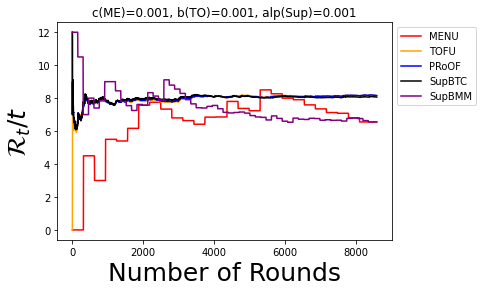

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 1


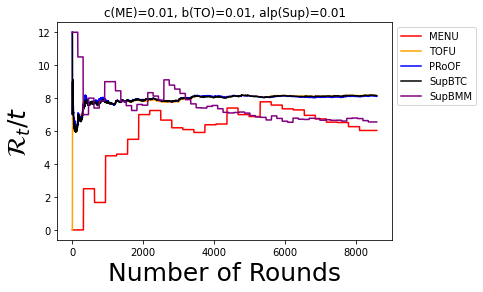

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 2


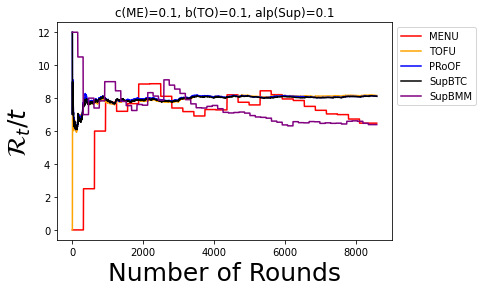

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 3


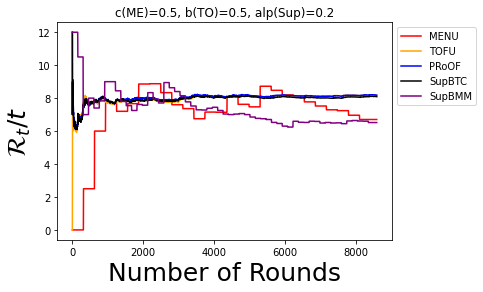

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 4


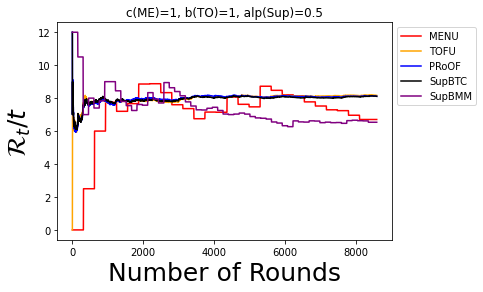

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 5


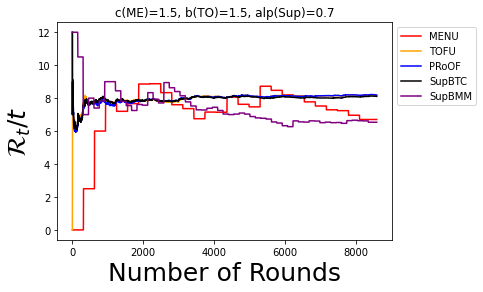

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 6


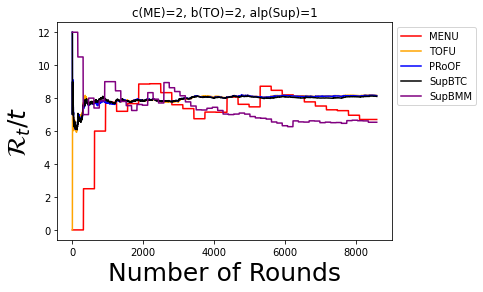

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 7


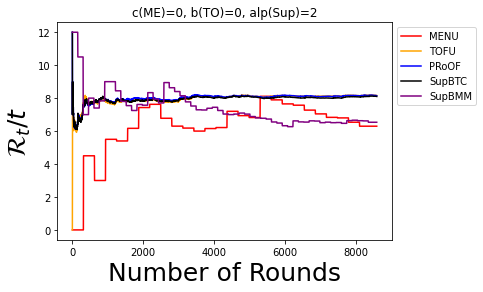

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 8


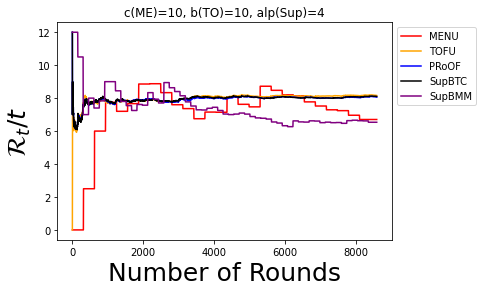

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 9


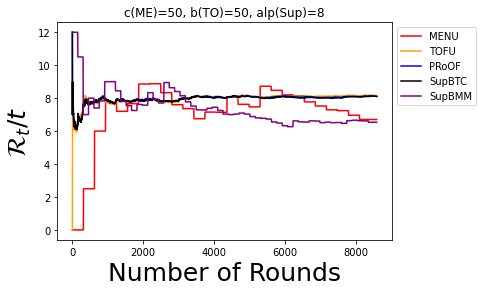

<Figure size 1440x1080 with 0 Axes>

20%
40%


/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


60%
80%
iter : 1
total play = 10


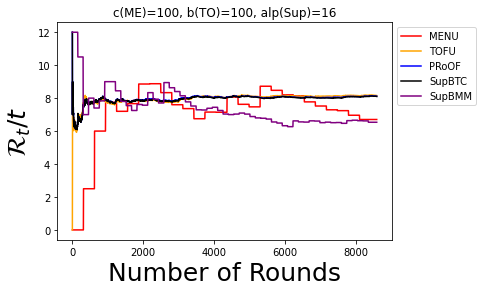

<Figure size 1440x1080 with 0 Axes>

In [15]:
for k in range(11):
    iter = 0
    err = np.zeros((5,8600))
    while(iter < 1):
        error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=c_s[k])
        err[0][:] += error_list
        print('20%')
        
        error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=b_s[k])
        err[1][:] += error_list
        print('40%')
        
        error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p, alpha=alp_s[k])
        err[2][:] += error_list
        print('60%')
        
        error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p, alpha=alp_s[k])
        err[3][:] += error_list
        print('80%')
        
        error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p, alpha=alp_s[k])
        err[4][:] += error_list
        
        iter += 1
        print('iter : %d' %iter)
    # err /= 10
    
    print('total play = %d' %(k+1))
    
    title = 'c(ME)=' + str(c_s[k]) + ', b(TO)=' + str(b_s[k]) + ', alp(Sup)=' + str(alp_s[k])
    plt.title(title)
    plt.plot(err[0], color='red', label='MENU')
    plt.plot(err[1], color='orange', label='TOFU')
    plt.plot(err[2], color='blue', label='PRoOF')
    plt.plot(err[3], color='black', label='SupBTC')
    plt.plot(err[4], color='purple', label='SupBMM')

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Number of Rounds",fontsize=25)
    plt.ylabel("$\mathcal{R}_{t}/t$ ",fontsize=25)
    plt.figure(figsize=(20,15))
    plt.show()

In [ ]:
for p in p:
    for delta in c_s:
        for nu in b_s:
            # df2 = df2.sample(frac=1)
            # df3 = df2.drop(['number of play', 'track'],axis=1)
            # df3 = df3.astype(float)
            # df3 = df3 / 100
            
            # y = df2['number of play'].to_numpy()
            # X = df3.to_numpy()
            # dim = X.shape[1]
            # total_samples = len(y)

            # T = 3700
            # K = int(total_samples/T)

            # D = np.reshape(X, (T,K,dim))
            # R = np.reshape(y, (T,K))

            # get_mean = lambda x, y: R[y]
            # get_observation = lambda x, y, z: R[y][z]
            err = np.zeros((5,T))
            error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
            err[0] = error_list

            error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
            err[1] = error_list

            error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
            err[2] = error_list

            error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
            err[3] = error_list

            error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)
            err[4] = error_list
            
            title = 'p=' + str(p) + ', delta=' + str(delta) + ', nu=' + str(nu)
            plt.title(title)
            plt.plot(err[0], color='red', label='MENU')
            plt.plot(err[1], color='orange', label='TOFU')
            plt.plot(err[2], color='blue', label='PRoOF')
            plt.plot(err[3], color='black', label='SupBTC')
            plt.plot(err[4], color='purple', label='SupBMM')

            plt.legend(bbox_to_anchor=(1, 1))
            plt.xlabel("Number of Rounds",fontsize=25)
            plt.ylabel("$\mathcal{R}_{t}/t$ ",fontsize=25)
            plt.figure(figsize=(20,15))
            plt.show()



In [ ]:
# error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
# error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
# error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
# error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
# error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)